A project to analyze and classify the sentiment of text data.
# Sentiment Analysis of Tweets
This project involves analyzing tweets to classify their sentiment as positive or negative using machine learning techniques. The dataset used contains tweets labeled with their corresponding sentiment. 
- Positive sentiment (1) 
- Negative sentiment (0)

In [2]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


**Stopwords**: 
 are commonly used words (such as "the", "is", "in", "and") that do not carry significant meaning and are `often removed from text` data during preprocessing to improve the performance of natural language processing (NLP) models.

**NLTK (Natural Language Toolkit)** is a popular Python library used for natural language processing (NLP) tasks. It provides tools and resources for tasks such as tokenization, stemming, lemmatization, part-of-speech tagging, and more.

In [3]:
import nltk
stops = nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ali
[nltk_data]     Baba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
print(f'Downloaded stopwords: {stopwords.words("english")}')
print(f'Stopwords count: {len(stopwords.words("english"))}')

Downloaded stopwords: ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 

### Dataset :

In [5]:
# Overview of the dataset
df = pd.read_csv('Twitter_Data.csv')
df.head(2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0


In [6]:
df['category'].value_counts()

category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [9]:
# Checking the info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162969 non-null  object 
 1   category    162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


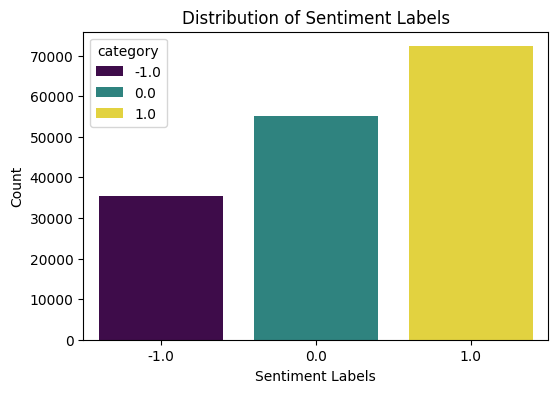

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x='category', data=df, palette='viridis', hue='category')
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

**Stemming** is the process of `reducing words to their root` or base form. \
*For example*, the words "running", "runner", and "ran" can all be reduced to the stem "run". \
Stemming helps in **normalizing text data and reducing the dimensionality** of the feature space, which can improve the performance of machine learning models in NLP tasks.

In [11]:
# Text Preprocessing: Stemming
port_stem = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]', ' ', content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_stem.stem(words) for words in stemmed_content if words not in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content


In [12]:
# Applying stemming to the 'tweet' column
df['tweet'] = df['clean_text'].apply(stemming)

In [13]:
# Displaying the first few rows of the processed dataset
df = df[['tweet', 'category']]
df.head()

,tweet,category
0,modi promis minimum govern maximum govern expe...,-1.0
1,talk nonsens continu drama vote modi,0.0
2,say vote modi welcom bjp told rahul main campa...,1.0
3,ask support prefix chowkidar name modi great s...,1.0
4,answer among power world leader today trump pu...,1.0


**Td-idf Vectorization** is a technique used to `convert text data into numerical features` that can be used by machine learning algorithms. \
It combines two metrics: Term Frequency (TF) and Inverse Document Frequency (IDF).
- **Term Frequency (TF)**: Measures how frequently a term occurs in a document.
- **Inverse Document Frequency (IDF)**: Measures how important a term is by considering its rarity across all documents.


In [14]:
# Aplying Tf-idf Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['tweet'])
y = df['category']

In [15]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [16]:
# Handling class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [17]:
X_train_res.shape, y_train_res.shape

((173397, 5000), (173397,))

In [18]:
# Training the Linear SVC model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=5000, class_weight='balanced')
model.fit(X_train_res, y_train_res)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,5000
,multi_class,'deprecated'


In [19]:
# predicting on the test set
y_pred = model.predict(X_test)

In [20]:
# Evaluating the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 5635   702   765]
 [  584  9942   516]
 [ 1151  1384 11915]]

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.76      0.79      0.78      7102
         0.0       0.83      0.90      0.86     11042
         1.0       0.90      0.82      0.86     14450

    accuracy                           0.84     32594
   macro avg       0.83      0.84      0.83     32594
weighted avg       0.85      0.84      0.84     32594



In [21]:
# Example prediction
def predict_sentiment(tweet):
    tweet = stemming(tweet)
    tweet_vector = tfidf.transform([tweet])
    prediction = model.predict(tweet_vector)
    return 'Positive' if prediction[0] == 1 else 'Negative'

# Example
new_tweet = "I love programming!"
print(f'Tweet: {new_tweet} | Sentiment: {predict_sentiment(new_tweet)}')

Tweet: I love programming! | Sentiment: Positive


In [22]:
# Saving the model and vectorizer
import pickle

# Save model
pickle.dump(model, open("model.pkl", "wb"))

# Save Td-idf vectorizer
pickle.dump(tfidf , open("vectorizer.pkl", "wb"))
